In [89]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

In [90]:
class RNN(nn.Module): # nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # i2h = input to hidden
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # i2o = input to output
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combine = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combine)
        output = self.i2o(combine)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [91]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(n_categories)

18


In [92]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor, hidden_tensor)
# print(output.size())
# print(next_hidden.size())

In [93]:
# Whole Sequence / Name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor[0], hidden_tensor)
# print(output.size())
# print(next_hidden.size())

In [94]:
def category_from_output(output):
    category_index = torch.argmax(output).item()
    return all_categories[category_index]

print(category_from_output(output))

Spanish


In [95]:
criterion = nn.NLLLoss() # Negative Log Likelihood Loss
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [96]:
def training_step(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [97]:
current_loss = 0
all_losses = []
plot_steps, print_steps= 1000 ,5000
n_iterations = 100000
for i in range(n_iterations):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = training_step(line_tensor, category_tensor)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss/plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"INCORRECT ({category})"
        print(f"Current Step:{i} {i/n_iterations*100}, Loss: {loss:.4f}, Current Line: {line}, Guess:{guess}, Accuracy: {correct}")

Current Step:4999 4.999, Loss: 2.4598, Current Line: Acciaio, Guess:Italian, Accuracy: CORRECT
Current Step:9999 9.998999999999999, Loss: 2.8674, Current Line: Kurmochi, Guess:Polish, Accuracy: INCORRECT (Japanese)
Current Step:14999 14.999, Loss: 2.9045, Current Line: Cantu, Guess:Polish, Accuracy: INCORRECT (Italian)
Current Step:19999 19.999, Loss: 2.4025, Current Line: Ewles, Guess:Dutch, Accuracy: INCORRECT (English)
Current Step:24999 24.999, Loss: 0.9875, Current Line: Chau, Guess:Vietnamese, Accuracy: CORRECT
Current Step:29999 29.999, Loss: 1.3148, Current Line: Fernandes, Guess:Portuguese, Accuracy: CORRECT
Current Step:34999 34.999, Loss: 1.5057, Current Line: Mendoza, Guess:Spanish, Accuracy: CORRECT
Current Step:39999 39.999, Loss: 1.6350, Current Line: Pak, Guess:Chinese, Accuracy: INCORRECT (Korean)
Current Step:44999 44.999, Loss: 1.5248, Current Line: Kenley, Guess:English, Accuracy: CORRECT
Current Step:49999 49.999, Loss: 0.0238, Current Line: Vassilikos, Guess:Greek

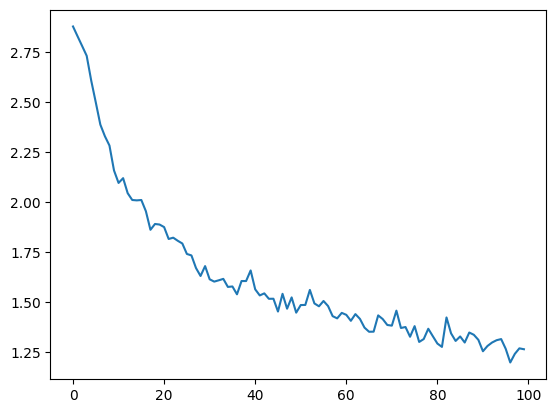

In [104]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [99]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    guess = category_from_output(output)
    print(guess)

In [103]:
while True:
    sentence = input("Input: ")
    if sentence == "quit":
        break
        
    predict(sentence)


> Muller
Scottish

> Hoang
Vietnamese

> Bao
Vietnamese

> Abbadelli
Italian

> Müller
Scottish

> Rogers
Dutch
